In [350]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [351]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.  # landing platform height
w1 = [-PLATFORM_WIDTH, PLATFORM_WIDTH]
w2 = [0.1*-PLATFORM_WIDTH, 0.1*PLATFORM_WIDTH]
h = [PLATFORM_HEIGHT, PLATFORM_HEIGHT]
ROTATION_ACCEL = np.radians(20)  # rotation constant

In [352]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """

        delta_state_ori = ROTATION_ACCEL* FRAME_TIME*t.tensor([0., 1, 0., 0., 0., 0.])

        sin = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [-1., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.]]),t.sin(t.transpose(state,0,1)))
        cos = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [1., 0., 0., 0., 0., 0.]]),t.cos(t.transpose(state,0,1)))
        cos_sin = cos+sin
        cos_sin = t.transpose(cos_sin,0,1)
        delta_state_pos = BOOST_ACCEL* FRAME_TIME*t.tensor([0., 0., 0., 1., 0., 1.])*cos_sin # x and y components of acceleration

        delta_state_combine = delta_state_ori + delta_state_pos

        action_mat = t.tensor([[0., 0.],
                         [2., 0.],
                         [0., 0.],
                         [0., 1.],
                         [0., 0.],
                         [0., 1.]])

        a_a = t.add(t.transpose(t.matmul(action_mat, t.transpose(action,0,1)),0,1) , t.tensor([0., -1., 0., 0., 0., 0.]))# get ori and pos accelerations

        delta_state = delta_state_combine*a_a

        state_gravity = GRAVITY_ACCEL * FRAME_TIME*t.tensor([0., 0., 0., 0., 0., -1.])
        state = state + delta_state + state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME,],
                             [0., 0., 0., 0., 0., 1.]])
        state = t.transpose(t.matmul(step_mat, t.transpose(state,0,1)),0,1)

        return state

In [353]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden1, dim_hidden2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [354]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, N):
        super(Simulation, self).__init__()
        self.state = self.initialize_state(N)
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state(n):
        initial = np.zeros((n,6))
        for i in range(n):
            initial[i] = [0.5*math.pi*(random.random()-0.5), 0.1*math.pi*(random.random()-0.5), # orientation state
                     (random.random()-0.5), 0.1*(random.random()-0.5), # horizontal state
                     0.5*random.random()+1, -0.1*random.random()]  # vertical state
        print('Generate %d initial states of rocket:' % n)
        print(initial)
        return t.tensor(initial, requires_grad=False).float()
    def error(self, state):
        states = t.square(state).sum(dim=0)*t.tensor([1., 1., 0.01, 1., 1., 1.]) # weight of each state
        return states.sum(dim=0)

In [355]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, eps, max_epoch):
        conv_log = []
        conv_itr = []
        epoch = 0
        error = 100
        print('Start Training:')
        while error > eps and epoch <= max_epoch:
            loss = self.step()
            conv_log.append(loss.item())
            conv_itr.append(epoch)
            epoch += 1
            print('[%d] loss: %.5f' % (epoch, loss))
            error = loss.item()
        #     cord = self.visualize()
        # print('Landing Trajectory:')
        # for r in range(N):
        #     plt.quiver(cord[:,r, 2], cord[:,r, 4], -0.05*np.sin(cord[:,r, 0]), 0.05*np.cos(cord[:,r, 0]))
        #     plt.quiver(cord[-1,r, 2], cord[-1,r, 4], -0.05*np.sin(cord[-1,r, 0]), 0.05*np.cos(cord[-1,r, 0]),color='orange')
        #     plt.plot(w1, h, color="red", linewidth=3)
        #     plt.plot(w2, h, color="green", linewidth=3)
        #     plt.show()
        print('Convergence Plot:')
        plt.plot(conv_itr, conv_log)
        plt.yscale("log")
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.scatter(data[:,0,2], data[:,0,4],s=5)
        plt.plot(w1, h, color="red", linewidth=3)
        plt.plot(w2, h, color="green", linewidth=3)
        plt.show()
        return data

In [356]:
class Evaluation:
    def __init__(self, simulation):
        self.simulation = simulation

    def test(self, n):
        print('Start Testing:')
        loss = self.simulation(self.simulation.state)
        print('loss: %.5f' % loss)
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        print('Landing Trajectory:')
        for r in range(n):
            plt.quiver(data[:,r, 2], data[:,r, 4], -0.05*np.sin(data[:,r, 0]), 0.05*np.cos(data[:,r, 0]))
            plt.quiver(data[-1,r, 2], data[-1,r, 4], -0.05*np.sin(data[-1,r, 0]), 0.05*np.cos(data[-1,r, 0]),color='orange')
            plt.plot(w1, h, color="red", linewidth=3)
            plt.plot(w2, h, color="green", linewidth=3)
            plt.show()
            end = data[-1,r,:]
            print(np.abs(end))

Generate 100 initial states of rocket:
[[ 5.19061606e-01 -1.33936294e-01 -2.64778838e-01  4.91096707e-02
   1.46470303e+00 -5.63618347e-02]
 [ 6.72103552e-01  1.03314411e-01  6.97448987e-02  4.05262881e-02
   1.35212424e+00 -7.79397030e-02]
 [-4.08797804e-01 -1.11029849e-01 -3.61546748e-01 -1.45086843e-02
   1.09768142e+00 -4.87950567e-02]
 [ 4.18020381e-01 -1.22837514e-01 -3.88718807e-01 -1.34832962e-02
   1.00467754e+00 -6.10753464e-02]
 [ 7.56794740e-02 -1.11270502e-01 -1.70841160e-01 -4.53528998e-02
   1.42159104e+00 -1.17913276e-02]
 [ 6.03670505e-01  3.65214715e-02  9.16479142e-02  9.34825326e-03
   1.16029142e+00 -3.56586324e-02]
 [ 5.92884272e-01  4.47974253e-02  9.86443769e-02 -2.80084338e-02
   1.39236018e+00 -1.57098958e-02]
 [ 1.00523385e-01  1.42898223e-01  1.83326969e-01 -4.51579979e-02
   1.32168981e+00 -3.31053079e-02]
 [-4.33504541e-01 -8.15383536e-02 -1.22305447e-01  9.02784032e-03
   1.21923125e+00 -3.03822562e-02]
 [ 3.18131532e-01 -8.17464757e-02  4.43526645e-01  1

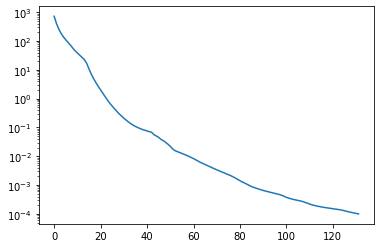

In [357]:
# Now it's time to run the code!

T = 100  # number of time steps
N = 100  # number of initial states
err = 0.0001 # acceptable_error
itr = 150 # max_iteration
dim_input = 6  # state space dimensions
dim_hidden1 = 12  # latent dimensions
dim_hidden2 = 4  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden1, dim_hidden2, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation
o = Optimize(s)  # define optimizer
o.train(err,itr)  # solve the optimization problem

path = './Landing_Model.pth' # save model
t.save(c.state_dict(),path)

Generate 10 initial states of rocket:
[[-0.29440276  0.13090376  0.04866485 -0.00413353  1.46856667 -0.03593214]
 [ 0.58952311  0.0555487   0.20973815  0.02040769  1.18505043 -0.03084207]
 [ 0.47180823  0.15690918 -0.43167372  0.0053526   1.15977429 -0.07940337]
 [ 0.09887439 -0.07413945 -0.0851267  -0.00904064  1.06134461 -0.06053441]
 [-0.47328188  0.05654516  0.17053566  0.02292688  1.0628448  -0.02240752]
 [-0.75900123  0.0050515  -0.31320634  0.04550927  1.28387908 -0.04057696]
 [ 0.05577068 -0.01958319 -0.30914486  0.00435749  1.13348399 -0.03766257]
 [-0.49450938  0.04780866 -0.29877737 -0.02643943  1.309481   -0.00779986]
 [-0.39124635 -0.15050329 -0.29400114 -0.04456455  1.22145869 -0.03487264]
 [-0.6221322   0.08319096  0.44222531  0.02822468  1.46971147 -0.00971042]]
Start Testing:
loss: 0.00064
Landing Trajectory:


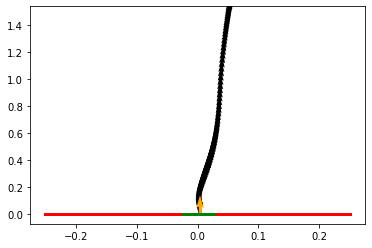

[1.6203710e-04 7.4187631e-04 3.8977629e-03 1.8586488e-04 3.2036707e-05
 1.6391557e-04]


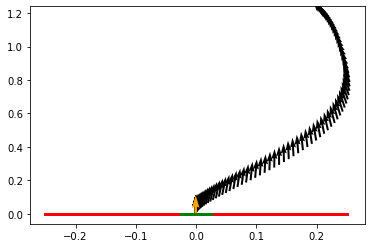

[3.16469057e-04 2.99052539e-04 7.11363158e-04 9.06133137e-05
 9.71181726e-05 1.00686215e-04]


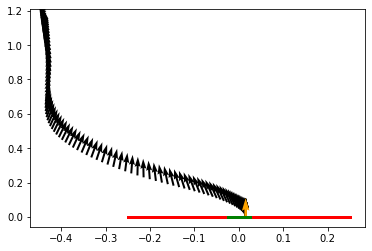

[2.6227802e-04 1.7622938e-02 1.5384991e-02 1.3244207e-04 1.1108998e-03
 2.0191073e-06]


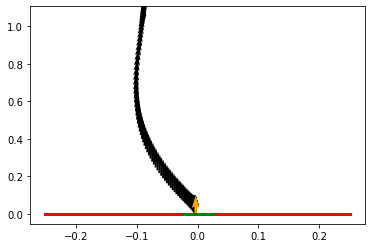

[8.7212255e-05 4.6802783e-05 3.1751161e-03 1.6271514e-04 3.7153048e-05
 3.8054772e-05]


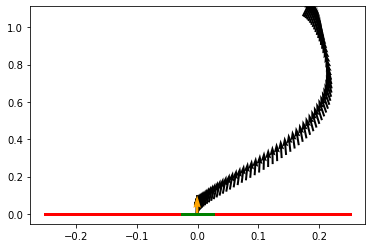

[0.00048707 0.00039497 0.00075061 0.00011768 0.00015934 0.00019539]


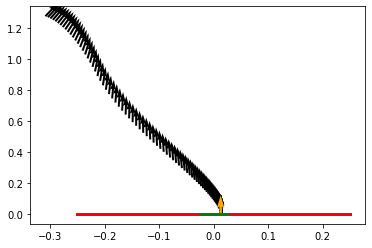

[8.3789282e-04 5.8195379e-04 1.2975448e-02 5.8354961e-04 2.1128188e-04
 8.3167106e-07]


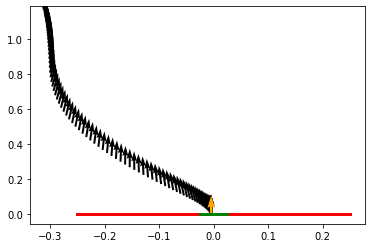

[1.4226419e-04 4.4473476e-05 4.3050353e-03 2.1979638e-04 5.3764754e-05
 3.0841678e-05]


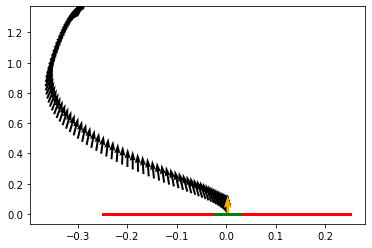

[2.8084981e-04 4.6709814e-04 3.1410339e-03 3.9729082e-05 1.6864206e-04
 5.9437007e-05]


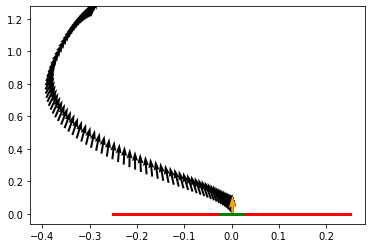

[8.9056505e-04 1.5197157e-04 2.1487183e-03 7.2114475e-05 1.7251444e-04
 1.0154117e-04]


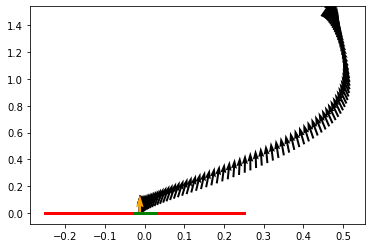

[0.00089758 0.01751567 0.01206206 0.00059671 0.00160672 0.00279203]


In [358]:
N_eval = 10 # number of initial states for testing
d_eval = Dynamics()  # define dynamics
model_eval =  Controller(dim_input, dim_hidden1, dim_hidden2, dim_output) # define controller

path = './Landing_Model.pth' # load model
model_eval.load_state_dict(t.load(path))
model_eval.eval()

s_eval = Simulation(model_eval, d_eval, T, N_eval )
eva = Evaluation(s_eval)  # initial evaluation simulator
eva.test(N_eval) # Test